In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import scipy.stats as st
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. 데이터 전처리
# -----------------------------
df = pd.read_csv("/Users/gun/Desktop/경종설/국내/ML_quant/test_merged.csv", parse_dates=["기준월"])

# 로그 변환
df["1M_log"] = np.log1p(df["next_1M_return"])
df["3M_log"] = np.log1p(df["next_3M_return"])

# 윈저라이즈 상하위 0.5%
def winsorize(series, alpha=0.005):
    lower = series.quantile(alpha)
    upper = series.quantile(1 - alpha)
    return series.clip(lower, upper)

for col in ["1M_log", "3M_log"]:
    df[col] = winsorize(df[col])

# -----------------------------
# 2. 모델링: LGBM + 5대 팩터
# -----------------------------
FEATURES = ["value_score", "quality_score", "momentum_score", "size_score", "lowvol_score"]

# -----------------------------
# 3~5. 시그널 생성 + Rolling CV
# -----------------------------
train_windows = [6, 8, 10]
stride = 1
test_window = 1
top_pct = 0.3
tc = 0.0005  # 거래비용 0.05%

records = []

months = sorted(df["기준월"].unique())
for train_window in train_windows:
    for start in range(0, len(months) - train_window - test_window + 1, stride):
        train_m = months[start:start + train_window]
        test_m = months[start + train_window:start + train_window + test_window]

        df_tr = df[df["기준월"].isin(train_m)]
        df_te = df[df["기준월"].isin(test_m)]

        model = lgb.LGBMRegressor(objective='regression', random_state=42, n_estimators=100)
        model.fit(df_tr[FEATURES], df_tr["3M_log"])

        y_true_log = df_te["3M_log"]
        y_pred_log = model.predict(df_te[FEATURES])
        y_true = np.expm1(y_true_log)
        y_pred = np.expm1(y_pred_log)

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rank_ic = st.pearsonr(y_true_log, y_pred_log)[0]
        hit_ratio = np.mean(np.sign(y_true_log) == np.sign(y_pred_log))

        tmp = df_te.copy()
        tmp["pred"] = y_pred_log
        tmp = tmp.sort_values("pred", ascending=False).reset_index(drop=True)

        n = len(tmp)
        k = int(n * top_pct)
        tmp["signal"] = 0
        if k > 0:
            tmp.loc[:k-1, "signal"] =  1
            tmp.loc[n-k:, "signal"] = -1
        turnover = 2 * k / n
        pnl = tmp["signal"] * tmp["next_3M_return"] - turnover * tc
        sharpe = pnl.mean() / (pnl.std() + 1e-9) * np.sqrt(12)

        records.append({
            "train_end": train_m[-1],
            "test_end": test_m[-1],
            "train_months": train_window,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "Rank_IC": rank_ic,
            "Hit_Ratio": hit_ratio,
            "Sharpe(3M_LS)": sharpe
        })

# -----------------------------
# 6. 결과 정리
# -----------------------------
df_results = pd.DataFrame(records)
print(df_results)

print("\n=== 평균 성과 요약 ===")
print("평균 RMSE     :", df_results["RMSE"].mean())
print("평균 MAE      :", df_results["MAE"].mean())
print("평균 R²       :", df_results["R2"].mean())
print("평균 Rank_IC :", df_results["Rank_IC"].mean())
print("평균 Hit_Ratio:", df_results["Hit_Ratio"].mean())
print("평균 Sharpe  :", df_results['Sharpe(3M_LS)'].mean())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 9174, number of used features: 5
[LightGBM] [Info] Start training from score 0.004078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 9174, number of used features: 5
[LightGBM] [Info] Start training from score -0.013560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 9

=== Best Params (tc=0.0005) ===
rebalance_months     6.0000
top_pct              0.4000
tc                   0.0005
Sharpe              84.1839
CumReturn            0.1329
MaxDrawdown          7.5228
Name: 55, dtype: float64

![alt text](image-1.png)

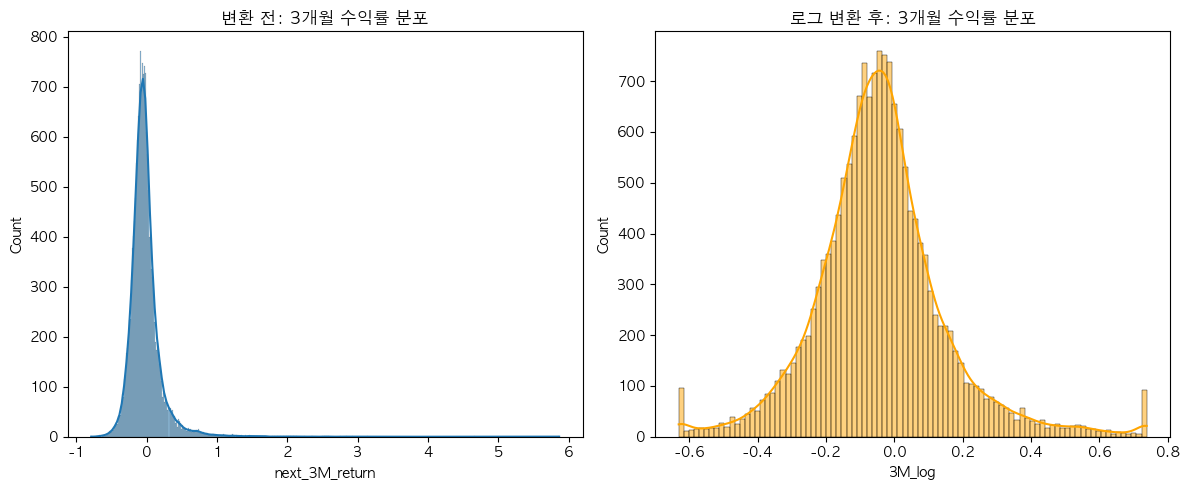

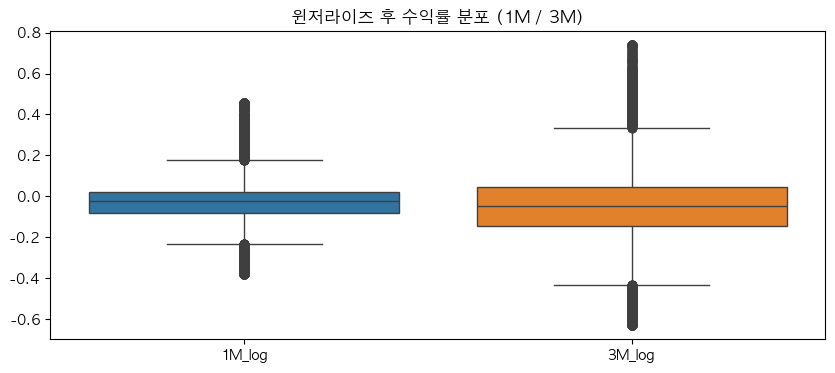

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 로그 변환 전후 분포 비교
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df["next_3M_return"], kde=True, ax=axs[0])
axs[0].set_title("변환 전: 3개월 수익률 분포")

sns.histplot(df["3M_log"], kde=True, ax=axs[1], color='orange')
axs[1].set_title("로그 변환 후: 3개월 수익률 분포")
plt.tight_layout()
plt.show()

# 📊 윈저라이즈 후 아웃라이어 제거 확인
plt.figure(figsize=(10, 4))
sns.boxplot(data=df[["1M_log", "3M_log"]])
plt.title("윈저라이즈 후 수익률 분포 (1M / 3M)")
plt.show()

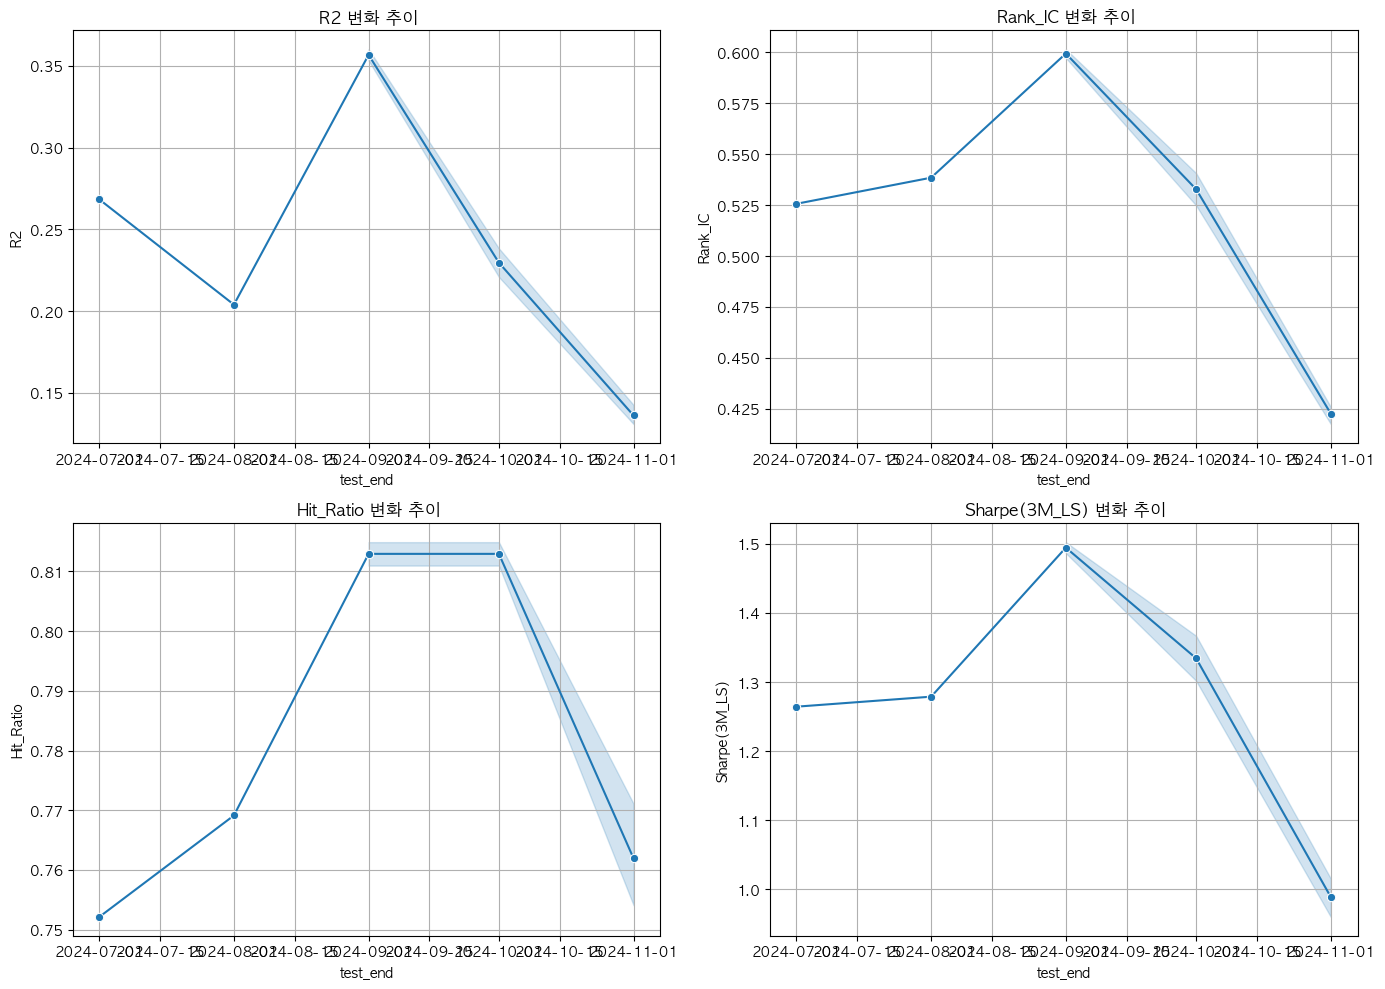

In [6]:
# 📈 Rolling 성과 시각화
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["R2", "Rank_IC", "Hit_Ratio", "Sharpe(3M_LS)"]

for i, m in enumerate(metrics):
    ax = axs[i//2, i%2]
    sns.lineplot(data=df_results, x="test_end", y=m, marker='o', ax=ax)
    ax.set_title(f" {m} 변화 추이")
    ax.grid(True)

plt.tight_layout()
plt.show()

KOSPI 데이터를 다운로드합니다...
✅ KOSPI 데이터 준비 완료!
✅ 기존 매크로 캐시 로드 완료
1. 팩터 데이터 준비...
2. MEI 계산...
3. 국면 정의...
4. 백테스트 실행...

          - Performance Summary -
CAGR: -0.71%
MDD: -38.20%
Vol: 27.38%
Sharpe: -2.59%


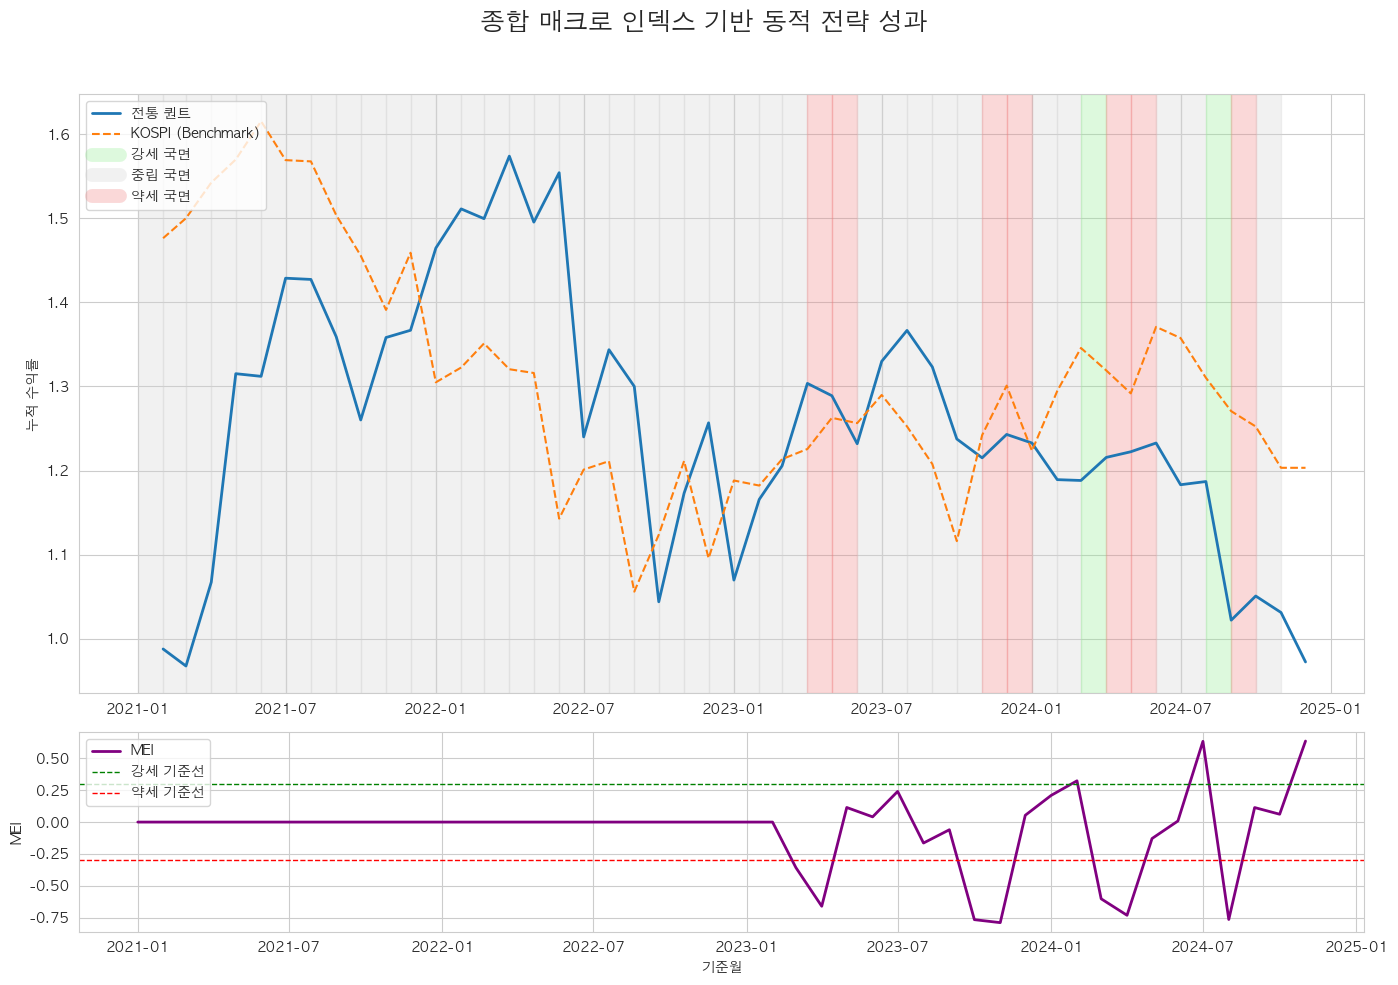


          - 국면 판단 로그 -
월: 2023-12, MEI: 0.05, 판단: 약세
월: 2024-01, MEI: 0.21, 판단: 중립
월: 2024-02, MEI: 0.32, 판단: 중립
월: 2024-03, MEI: -0.60, 판단: 강세
월: 2024-04, MEI: -0.73, 판단: 약세
월: 2024-05, MEI: -0.13, 판단: 약세
월: 2024-06, MEI: 0.01, 판단: 중립
월: 2024-07, MEI: 0.63, 판단: 중립
월: 2024-08, MEI: -0.76, 판단: 강세
월: 2024-09, MEI: 0.11, 판단: 약세
월: 2024-10, MEI: 0.06, 판단: 중립
월: 2024-11, MEI: 0.63, 판단: 중립

          - LGBM 3M 예측 테스트 -
평균 성과:
             Mean
RMSE    0.151014
MAE     0.101649
R2      0.274121
IC      0.554727
Hit     0.795509
Sharpe  1.399918


In [42]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import scipy.stats as st
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
from tqdm import tqdm
import FinanceDataReader as fdr
import os

# ------------------------------
# 한글 폰트 탐색 및 설정
# ------------------------------
try:
    plt.rc('font', family='AppleGothic')
except Exception as e:
    print(f"폰트 설정 오류: {e}. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------
# 유틸 함수
# ------------------------------
def winsorize(series, alpha=0.005):
    lo, hi = series.quantile(alpha), series.quantile(1 - alpha)
    return series.clip(lo, hi)

# ------------------------------
# 데이터 수집 함수
# ------------------------------
def get_kospi_data(start_date, end_date):
    print("KOSPI 데이터를 다운로드합니다...")
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=end_date)
    monthly = kospi_daily['Close'].resample('ME').last().pct_change().fillna(0)
    kospi_df = pd.DataFrame({'수익률': monthly}).reset_index()
    kospi_df.rename(columns={'Date':'기준월'}, inplace=True)
    kospi_df['기준월'] = pd.to_datetime(kospi_df['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!")
    return kospi_daily, kospi_df

def get_comprehensive_macro_data(start_date, end_date, kospi_daily):
    print("종합 매크로 데이터를 준비합니다...")
    symbols = {'환율':'USD/KRW', '유가':'WTI'}
    macro = {}
    for name, ticker in symbols.items():
        try:
            df = fdr.DataReader(ticker, start=start_date, end=end_date)
            macro[name] = df['Close'].resample('ME').last()
        except:
            print(f"{name} 데이터 수집 실패, 건너뜁니다.")
    vol = kospi_daily['Close'].pct_change().rolling(21).std() * np.sqrt(252)
    macro['변동성'] = vol.resample('ME').last()
    macro_df = pd.concat(macro, axis=1).ffill().bfill()
    macro_df = macro_df.rename_axis('기준월').reset_index()
    macro_df['기준월'] = pd.to_datetime(macro_df['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ 매크로 데이터 준비 완료!")
    return macro_df

# ------------------------------
# 동적 백테스터 클래스
# ------------------------------
class AdvancedDynamicBacktester:
    def __init__(self, df, kospi_df, macro_df, top_n=20, cost=0.003):
        self.df_original = df.copy()
        self.kospi_df    = kospi_df.copy()
        self.macro_df    = macro_df.copy()
        self.top_n       = top_n
        self.cost        = cost
        self.returns_df  = None
        self.metrics     = None
        self.regime_log  = []

        print("1. 팩터 데이터 준비...")
        self.df = self._prepare_factors(df)

        print("2. MEI 계산...")
        self._calculate_mei()

        print("3. 국면 정의...")
        self._define_regime_from_mei()

    def _prepare_factors(self, df):
        df = df.copy()
        df['value_score']    = -df['PBR']
        df['quality_score']  = df['ROE']
        df['momentum_score'] = df['12개월수익률']
        df['eps_score']      = df['EPS']
        df = df.sort_values(['종목코드','기준월'])
        df['volatility']      = df.groupby('종목코드')['1개월수익률'].transform(lambda x: x.rolling(12,6).std())
        df['volatility_score']= -df['volatility']
        cols = ['value_score','quality_score','momentum_score','eps_score','volatility_score']
        for c in cols:
            df[c] = df.groupby('기준월')[c].transform(
                lambda x: (x-x.min())/(x.max()-x.min()) if x.nunique()>1 else 0.5
            )
        df[cols] = df[cols].fillna(0.5)
        return df

    def _calculate_mei(self):
        df = pd.merge(self.df, self.macro_df, on='기준월', how='left')
        df[self.macro_df.columns.drop('기준월')] = df[self.macro_df.columns.drop('기준월')].ffill().bfill()
        proc = df.set_index(['기준월','종목코드'])
        for name in ['환율','유가','변동성']:
            if name in proc: 
                proc[f'{name}_trend'] = proc[name].diff(3)
        for col in proc.columns:
            if '_trend' in col:
                m = proc[col].rolling(24).mean()
                s = proc[col].rolling(24).std()
                proc[f'{col}_z'] = ((proc[col]-m)/s).fillna(0)
        proc = proc.fillna(0)
        self.df = proc.reset_index()
        self.df['MEI'] = 0
        score_map = {'변동성_trend_z':-1, '환율_trend_z':-1, '유가_trend_z':1}
        cnt = 0
        for col, d in score_map.items():
            if col in self.df:
                self.df['MEI'] += self.df[col] * d
                cnt += 1
        if cnt>0:
            self.df['MEI'] /= cnt

    def _define_regime_from_mei(self):
        cond = [self.df['MEI']>0.3, self.df['MEI']<-0.3]
        cho  = ['강세','약세']
        self.df['Regime'] = np.select(cond, cho, default='중립')
        self.df['Regime'] = self.df.groupby('종목코드')['Regime'].shift(1).ffill().bfill()

    def run_backtest(self,):
        print("4. 백테스트 실행...")
        rets = []
        self.regime_log = []
        dates = sorted(self.df_original['기준월'].unique())
        for i, d in enumerate(dates[:-1]):
            cur = self.df[self.df['기준월']==d]
            if cur.empty:
                continue
            reg = cur['Regime'].iloc[0]
            mei = cur['MEI'].iloc[0]
            # 국면 로그 기록
            self.regime_log.append({'기준월': d, '판단국면': reg, 'MEI': mei})
            # composite score
            if reg=='강세':
                cs = 0.5*cur['momentum_score'] + 0.5*cur['eps_score']
            elif reg=='약세':
                cs = 0.5*cur['quality_score'] + 0.5*cur['volatility_score']
            else:
                cs = 0.5*cur['value_score'] + 0.5*cur['quality_score']
            top = cur.assign(composite=cs).nlargest(self.top_n, 'composite')
            nxt = self.df_original[
                (self.df_original['기준월']==dates[i+1]) &
                (self.df_original['종목코드'].isin(top['종목코드']))
            ]
            if not nxt.empty:
                rets.append(nxt['1개월수익률'].mean() - self.cost)
        self.returns_df = pd.Series(rets, index=dates[1:])
        self.metrics    = self._metrics(self.returns_df)
        print("\n" + "="*50); print("          - Performance Summary -"); print("="*50)
        for k, v in self.metrics.items():
            print(f"{k}: {v:.2%}")

    def _metrics(self, s):
        if len(s)<2:
            return {}
        cum    = (1+s).cumprod()
        cagr   = cum.iloc[-1]**(12/len(s)) - 1
        peak   = cum.expanding().max()
        mdd    = (cum/peak - 1).min()
        vol    = s.std() * np.sqrt(12)
        sharpe = cagr/vol if vol else 0
        return {'CAGR':cagr, 'MDD':mdd, 'Vol':vol, 'Sharpe':sharpe}

    def plot_results(self):
        if self.returns_df is None or self.returns_df.empty:
            return

        # (1) 누적수익률
        port_cum = (1 + self.returns_df).cumprod()
        bench_series = self.kospi_df.set_index('기준월')['수익률']
        bench_cum_full = (1 + bench_series).cumprod()
        bench_cum = bench_cum_full.reindex(port_cum.index, method='ffill')

        # (2) 국면 로그
        regime_df = pd.DataFrame(self.regime_log).drop_duplicates('기준월').set_index('기준월')

        # (3) 플롯
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,10), gridspec_kw={'height_ratios':[3,1]})
        fig.suptitle('종합 매크로 인덱스 기반 동적 전략 성과', fontsize=18)

        # 누적수익률 + 국면 음영
        ax1.plot(port_cum.index, port_cum.values, label='전통 퀀트', lw=2)
        ax1.plot(bench_cum.index, bench_cum.values, ls='--', label='KOSPI (Benchmark)', lw=1.5)
        cmap = {'강세':'lightgreen','중립':'lightgray','약세':'lightcoral'}
        dates = regime_df.index.to_list()
        for i in range(len(dates)-1):
            ax1.axvspan(dates[i], dates[i+1],
                        color=cmap.get(regime_df['판단국면'].iloc[i], 'white'),
                        alpha=0.3)
        for reg, col in cmap.items():
            ax1.plot([],[], color=col, alpha=0.3, lw=10, label=f'{reg} 국면')
        ax1.set_ylabel('누적 수익률')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        # MEI 추이 + 기준선
        ax2.plot(regime_df.index, regime_df['MEI'], color='purple', lw=2, label='MEI')
        ax2.axhline(0.3, color='green', ls='--', lw=1, label='강세 기준선')
        ax2.axhline(-0.3, color='red', ls='--', lw=1, label='약세 기준선')
        ax2.set_ylabel('MEI')
        ax2.set_xlabel('기준월')
        ax2.legend(loc='upper left')
        ax2.grid(True)

        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()

# ------------------------------
# 메인 실행
# ------------------------------
if __name__ == '__main__':
    base       = '/Users/gun/Desktop/경종설/퀀트'
    stock_file = os.path.join(base, 'stock_0.3ver.csv')
    macro_file = os.path.join(base, 'macro_data_kr.csv')
    test_file  = os.path.join(base, 'test_merged.csv')

    # 1) 데이터 로드 & 매크로 수집
    df_stock = pd.read_csv(stock_file, parse_dates=['기준월'])
    dk, mk   = get_kospi_data(df_stock['기준월'].min() - pd.DateOffset(months=25),
                              df_stock['기준월'].max())

    if os.path.exists(macro_file):
        macro_df = pd.read_csv(macro_file, parse_dates=['기준월'])
        print("✅ 기존 매크로 캐시 로드 완료")
    else:
        macro_df = get_comprehensive_macro_data(
            df_stock['기준월'].min() - pd.DateOffset(months=25),
            df_stock['기준월'].max(), dk)
        macro_df.to_csv(macro_file, index=False)

    # 2) 동적 전략 백테스트 & 시각화
    bt = AdvancedDynamicBacktester(df_stock, mk, macro_df)
    bt.run_backtest()
    bt.plot_results()

    # 3) 최근 12개월 국면 로그 출력
    print("\n" + "="*50); print("          - 국면 판단 로그 -"); print("="*50)
    log_df = pd.DataFrame(bt.regime_log).drop_duplicates('기준월').set_index('기준월')
    for date, row in log_df.tail(12).iterrows():
        print(f"월: {date.strftime('%Y-%m')}, MEI: {row['MEI']:.2f}, 판단: {row['판단국면']}")

    # 4) 원본 LGBM 3M 예측 테스트 (성능 요약)
    print("\n" + "="*50); print("          - LGBM 3M 예측 테스트 -"); print("="*50)
    df = pd.read_csv(test_file, parse_dates=['기준월'])
    df['1M_log'], df['3M_log'] = np.log1p(df['next_1M_return']), np.log1p(df['next_3M_return'])
    df['1M_log'], df['3M_log'] = winsorize(df['1M_log']), winsorize(df['3M_log'])

    FEATURES   = ['value_score','quality_score','momentum_score','size_score','lowvol_score']
    top_pct = 0.4
    records    = []
    months_all = sorted(df['기준월'].unique())
    for w in [6,8,10]:
        for i in range(len(months_all)-w-1):
            train = months_all[i:i+w]
            test  = months_all[i+w:i+w+1]
            dtr   = df[df['기준월'].isin(train)]
            dte   = df[df['기준월'].isin(test)]
            mdl   = lgb.LGBMRegressor(objective='regression', random_state=42,
                                       n_estimators=100, verbose=-1)
            mdl.fit(dtr[FEATURES], dtr['3M_log'])
            pred_log = mdl.predict(dte[FEATURES])
            y_true   = np.expm1(dte['3M_log'])
            y_pred   = np.expm1(pred_log)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae  = mean_absolute_error(y_true, y_pred)
            r2   = r2_score(y_true, y_pred)
            ic   = st.pearsonr(dte['3M_log'], pred_log)[0]
            hit  = np.mean(np.sign(dte['3M_log']) == np.sign(pred_log))
            tmp  = dte.assign(pred=pred_log).sort_values('pred', ascending=False)
            n = len(tmp)
            k = int(n * top_pct)
            tmp['sig'] = 0
            if k>0:
                tmp.iloc[:k, tmp.columns.get_loc('sig')]   = 1
                tmp.iloc[n-k:, tmp.columns.get_loc('sig')] = -1
            pnl   = tmp['sig'] * tmp['next_3M_return'] - 2*k/n*0.0005
            sharpe= pnl.mean()/pnl.std()*np.sqrt(12)
            records.append({'win':w,'RMSE':rmse,'MAE':mae,'R2':r2,
                            'IC':ic,'Hit':hit,'Sharpe':sharpe})

    res     = pd.DataFrame(records)
    summary = res.mean()[['RMSE','MAE','R2','IC','Hit','Sharpe']]
    print("평균 성과:\n", summary.to_frame('Mean'))

In [21]:
# 파일 이름: 01_build_ultimate_dataset.py

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

def load_base_data(stock_filepath, macro_filepath):
    print("원본 데이터 로드를 시작합니다...")
    stock_df = pd.read_csv(stock_filepath, parse_dates=['기준월'])
    try:
        macro_df = pd.read_csv(macro_filepath, encoding='cp949')
    except UnicodeDecodeError:
        macro_df = pd.read_csv(macro_filepath, encoding='utf-8')
    macro_df['기준월'] = pd.to_datetime(macro_df['연도'].astype(str) + '-' + macro_df['월'].astype(str), format='%Y-%m')
    print("✅ 원본 데이터 로드 완료!")
    return stock_df, macro_df

def prepare_all_factors(df):
    """보유한 모든 데이터를 활용하여 팩터를 생성하고 스케일링합니다."""
    print("모든 팩터를 생성하고 스케일링합니다...")
    df = df.copy()
    # --- 최종 팩터 목록 (PER, Size, PSR 추가) ---
    factor_list = [
        'value_score', 'quality_score', 'momentum_score', 'size_score',
        'volatility_score', 'op_margin_score', 'debt_ratio_score', 
        'robust_momentum_score', 'attention_score'
    ]
    
    # 팩터 계산 (낮을수록 좋은 PBR, PER, 시가총액, 부채비율, 변동성은 음수로 변환)
    df['pbr_score'] = -df['PBR']
    df['per_score'] = -df['PER']
    df['psr_score'] = -df['PSR']
    df['value_score'] = df[['pbr_score', 'per_score', 'psr_score']].mean(axis=1) # 3가지 가치 지표 종합

    df['quality_score'] = df['ROE']
    df['momentum_score'] = df['12개월수익률']
    df['size_score'] = -df['시가총액']
    
    df = df.sort_values(by=['종목코드', '기준월'])
    df['volatility'] = df.groupby('종목코드')['1개월수익률'].transform(lambda x: x.rolling(12, 6).std())
    df['volatility_score'] = -df['volatility']
    df['op_margin_score'] = df['영업이익률']
    df['debt_ratio_score'] = -df['부채비율']
    df['robust_momentum_score'] = df['momentum_accel'] + df['trend_positive_count'] + df['momentum_trend_slope']
    df['attention_score'] = df['평균거래량증가율'] + df['거래회전율']

    for col in factor_list:
        df[col] = df.groupby('기준월')[col].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.nunique() > 1 else 0.5)
    df[factor_list] = df[factor_list].fillna(0.5)
    print("✅ 모든 팩터 준비 완료!")
    return df

def create_themed_macro_indices(macro_df):
    print("테마별 매크로 인덱스를 생성합니다..."); macro_proc = macro_df.set_index('기준월').copy(); macro_cols = ['WTI', 'VIX', '실업률', 'CPI', '금리', '환율']
    for col in macro_cols:
        change = macro_proc[col].diff(6); mean = change.rolling(24).mean(); std = change.rolling(24).std(); macro_proc[f'{col}_z_score'] = ((change - mean) / std).fillna(0)
    economy_cols, inflation_cols, sentiment_cols = ['실업률_z_score', '금리_z_score'], ['CPI_z_score', 'WTI_z_score'], ['VIX_z_score', '환율_z_score']
    macro_proc['Economy_Index'] = macro_proc[economy_cols].mean(axis=1) * -1; macro_proc['Inflation_Index'] = macro_proc[inflation_cols].mean(axis=1) * -1; macro_proc['Sentiment_Index'] = macro_proc[sentiment_cols].mean(axis=1) * -1
    feature_cols = ['Economy_Index', 'Inflation_Index', 'Sentiment_Index']; final_features = macro_proc[feature_cols].ffill().bfill()
    print("✅ 테마별 매크로 인덱스 생성 완료!"); return final_features.reset_index()

def create_dual_labels(df_original):
    print("알파/리스크 모델용 정답(Label) 데이터를 생성합니다..."); df = df_original.copy()
    df['next_month_return'] = df.groupby('종목코드')['1개월수익률'].shift(-1)
    df['y_alpha'] = (df['next_month_return'] > 0).astype(int); df['y_risk'] = (df['next_month_return'] < -0.15).astype(int)
    df.dropna(subset=['next_month_return'], inplace=True); print("✅ 정답 데이터 생성 완료!"); return df[['기준월', '종목코드', 'y_alpha', 'y_risk']]

if __name__ == '__main__':
    stock_filepath = "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv"; macro_filepath = "/Users/gun/Desktop/경종설/퀀트/거시경제 월별 지표 최종.csv"
    stock_df_raw, macro_df_raw = load_base_data(stock_filepath, macro_filepath)
    df_with_all_factors = prepare_all_factors(stock_df_raw)
    macro_features = create_themed_macro_indices(macro_df_raw)
    labels_df = create_dual_labels(stock_df_raw)
    
    print("모든 Feature와 Label을 최종 결합합니다...")
    final_df = pd.merge(df_with_all_factors, macro_features, on='기준월', how='left')
    final_df = pd.merge(final_df, labels_df, on=['기준월', '종목코드'], how='inner')
    final_df.ffill(inplace=True)

    print("Feature 중요도를 계산하여 최적의 Feature를 선별합니다...")
    features_for_selection = [col for col in final_df.columns if col.endswith('_score') or col.endswith('_Index')]
    X = final_df[features_for_selection]; y = final_df['y_alpha']
    model_for_fs = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_for_fs.fit(X, y)
    feature_importances = pd.Series(model_for_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(20).index.tolist()
    print(f"✅ 선택된 최상위 Feature:\n{top_features}")
    
    final_ml_dataset = final_df[['기준월', '종목코드'] + top_features + ['y_alpha', 'y_risk']]
    final_ml_dataset.to_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", index=False)
    df_with_all_factors.to_csv("/Users/gun/Desktop/경종설/퀀트/full_feature_stock_data.csv", index=False)
    
    print("\n--- 모든 데이터 준비가 완료되었습니다! ---"); print("생성된 파일: /Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv, full_feature_stock_data.csv")
    print("이제 '02_run_comparative_backtest.py'를 실행하여 백테스트를 진행하세요.")


원본 데이터 로드를 시작합니다...
✅ 원본 데이터 로드 완료!
모든 팩터를 생성하고 스케일링합니다...
✅ 모든 팩터 준비 완료!
테마별 매크로 인덱스를 생성합니다...
✅ 테마별 매크로 인덱스 생성 완료!
알파/리스크 모델용 정답(Label) 데이터를 생성합니다...
✅ 정답 데이터 생성 완료!
모든 Feature와 Label을 최종 결합합니다...
Feature 중요도를 계산하여 최적의 Feature를 선별합니다...
✅ 선택된 최상위 Feature:
['value_score', 'robust_momentum_score', 'quality_score', 'momentum_score', 'debt_ratio_score', 'size_score', 'attention_score', 'pbr_score', 'op_margin_score', 'psr_score', 'volatility_score', 'per_score', 'Economy_Index', 'Sentiment_Index', 'Inflation_Index']

--- 모든 데이터 준비가 완료되었습니다! ---
생성된 파일: /Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv, full_feature_stock_data.csv
이제 '02_run_comparative_backtest.py'를 실행하여 백테스트를 진행하세요.


--- 최종 머신러닝 백테스팅 실행 시작 ---
⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.
KOSPI 데이터를 다운로드합니다...
✅ KOSPI 데이터 준비 완료!
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.
전략 비교 백테스트를 실행합니다 (학습: 36개월)...

--- 학습: 2021-01~2023-12 | 검증: 2024-01~2024-06 ---
  - 알파 모델 학습 중...
  - 리스크 모델 학습 중...

--- 학습: 2021-01~2024-06 | 검증: 2024-07~2024-11 ---
  - 알파 모델 학습 중...
  - 리스크 모델 학습 중...

✅ 백테스트 완료!

                    - 최종 성과 비교 요약 -
               CAGR      MDD Volatility Sharpe Ratio
Dual-ML 전략   -9.22%  -12.54%     12.53%        -0.74
전통 퀀트       -17.91%  -38.00%     36.05%        -0.50


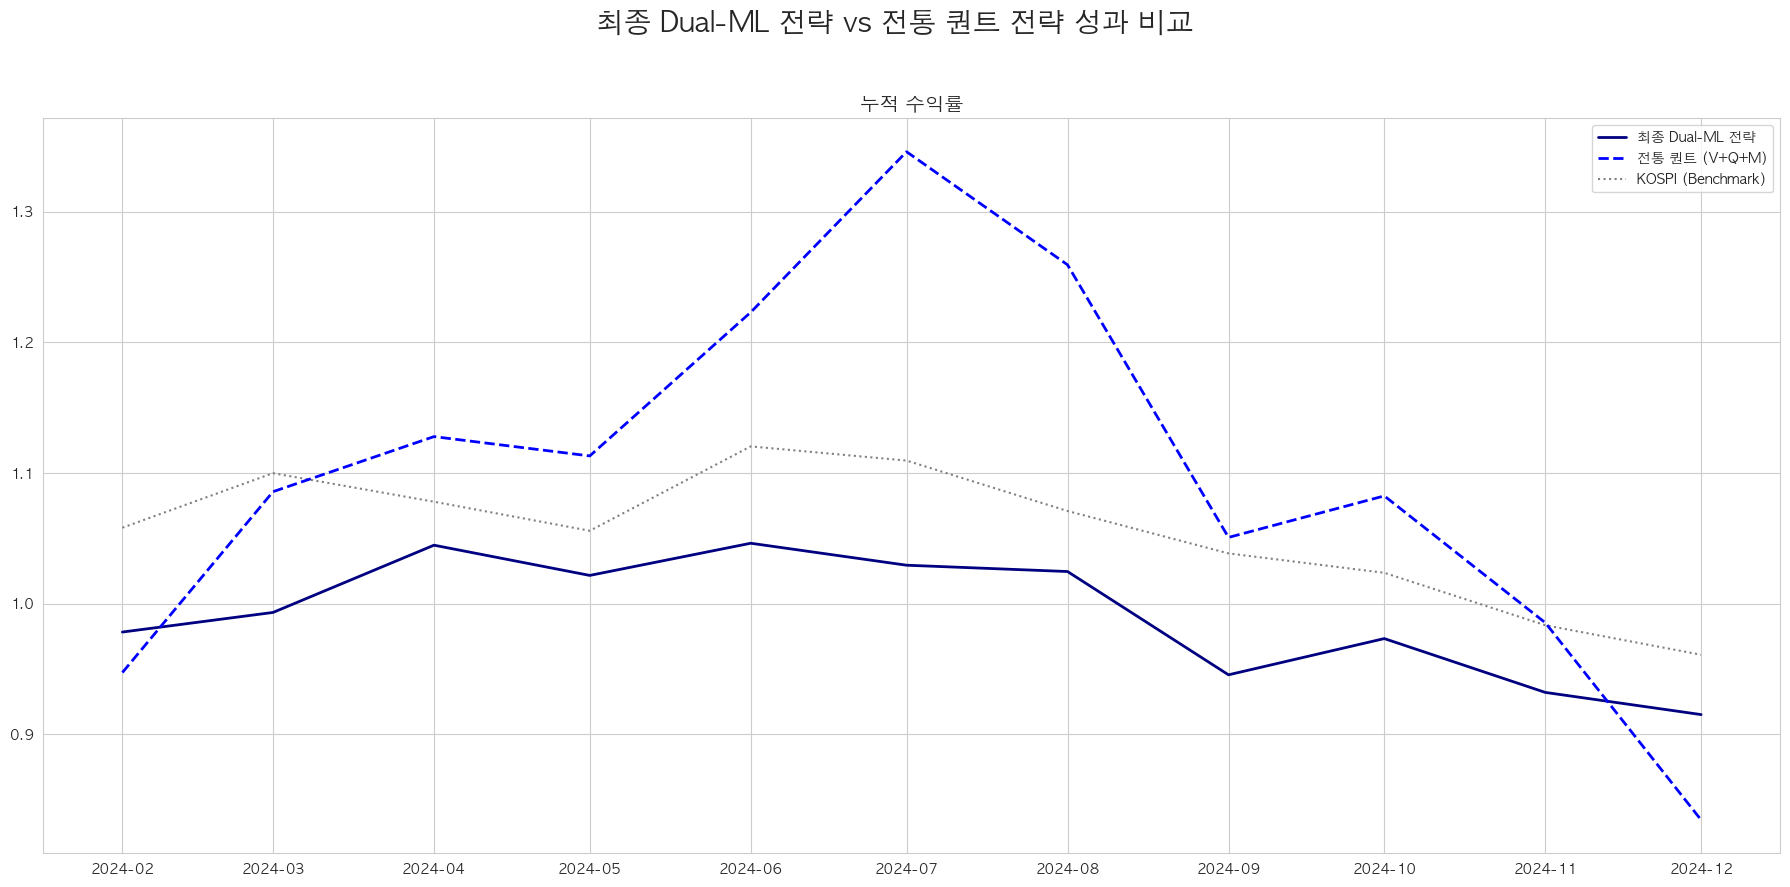

In [22]:
# 파일 이름: 02_run_comparative_backtest.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib 한글 폰트 설정 ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("한글 폰트 설정에 실패했습니다. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False

# --- 헬퍼 함수 ---
def get_kospi_data(start_date, end_date):
    """KOSPI 벤치마크 데이터를 수집합니다."""
    print("KOSPI 데이터를 다운로드합니다..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'수익률': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': '기준월'}, inplace=True)
    kospi_df_monthly['기준월'] = pd.to_datetime(kospi_df_monthly['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """성과 지표를 계산하는 헬퍼 함수"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- 최종 비교 백테스터 클래스 ---
class FinalComparativeBacktester:
    def __init__(self, ml_dataset, df_with_factors, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_with_factors = df_with_factors
        self.df_original = df_original
        self.top_n, self.cost = top_n, cost
        
        # --- 여기가 수정된 부분 ---
        # 결과 저장을 위한 변수들을 명확하게 초기화합니다.
        self.returns_df = None
        self.performance_summary = {} # 이 줄이 추가되었습니다.

    def run_backtest_comparison(self, train_months=36, test_months=6):
        print(f"전략 비교 백테스트를 실행합니다 (학습: {train_months}개월)...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        returns_ml, returns_traditional = [], []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            print(f"\n--- 학습: {train_start.strftime('%Y-%m')}~{train_end.strftime('%Y-%m')} | 검증: {test_start.strftime('%Y-%m')}~{test_end.strftime('%Y-%m')} ---")
            
            train_data = dataset[dataset['기준월'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            print("  - 알파 모델 학습 중..."); alpha_model = lgb.LGBMClassifier(random_state=42); alpha_model.fit(X_train, y_alpha_train)
            print("  - 리스크 모델 학습 중..."); risk_model = lgb.LGBMClassifier(random_state=42); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['기준월'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                # --- ML 전략 포트폴리오 ---
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(self.top_n * 2, 'alpha_score')
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                portfolio_ml = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist()
                
                # --- 전통 퀀트 전략 포트폴리오 ---
                current_factors_df = self.df_with_factors[self.df_with_factors['기준월'] == date]
                current_factors_df['traditional_score'] = current_factors_df['value_score'] + current_factors_df['quality_score'] + current_factors_df['momentum_score']
                portfolio_traditional = current_factors_df.nlargest(self.top_n, 'traditional_score')['종목코드'].tolist()

                # --- 다음달 수익률 계산 ---
                next_month_date = date + pd.DateOffset(months=1); next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                
                next_month_ml = next_month_data_orig[next_month_data_orig['종목코드'].isin(portfolio_ml)]
                returns_ml.append({'기준월': next_month_date, '수익률': (next_month_ml['1개월수익률'].mean() - self.cost) if not next_month_ml.empty else -self.cost})
                
                next_month_trad = next_month_data_orig[next_month_data_orig['종목코드'].isin(portfolio_traditional)]
                returns_traditional.append({'기준월': next_month_date, '수익률': (next_month_trad['1개월수익률'].mean() - self.cost) if not next_month_trad.empty else -self.cost})
            
            current_train_end_idx += test_months
        
        print("\n✅ 백테스트 완료!"); 
        df_ml = pd.DataFrame(returns_ml).set_index('기준월'); df_trad = pd.DataFrame(returns_traditional).set_index('기준월')
        self.returns_df = pd.concat([df_ml, df_trad], axis=1, keys=['Dual-ML 전략', '전통 퀀트']); self.returns_df.columns = self.returns_df.columns.droplevel(1)
        self.performance_summary['Dual-ML 전략'] = calculate_performance_metrics(self.returns_df['Dual-ML 전략'].dropna())
        self.performance_summary['전통 퀀트'] = calculate_performance_metrics(self.returns_df['전통 퀀트'].dropna())
        self.print_performance_summary()

    def print_performance_summary(self):
        print("\n" + "="*60); print(" " * 20 + "- 최종 성과 비교 요약 -"); print("="*60); 
        summary_df = pd.DataFrame.from_dict(self.performance_summary, orient='index');
        for col in summary_df.columns: summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
    def plot_results(self, kospi_df):
        if self.returns_df is None or self.returns_df.empty: return
        fig, ax1 = plt.subplots(1, 1, figsize=(18, 9)); fig.suptitle('최종 Dual-ML 전략 vs 전통 퀀트 전략 성과 비교', fontsize=20)
        cum_returns = (1 + self.returns_df.fillna(0)).cumprod(); 
        kospi_returns_aligned = kospi_df.set_index('기준월').loc[cum_returns.index]; 
        cum_returns_kospi = (1 + kospi_returns_aligned['수익률']).cumprod()
        ax1.plot(cum_returns.index, cum_returns['Dual-ML 전략'], label='최종 Dual-ML 전략', color='navy', lw=2, zorder=5)
        ax1.plot(cum_returns.index, cum_returns['전통 퀀트'], label='전통 퀀트 (V+Q+M)', color='blue', ls='--', lw=2, zorder=5)
        ax1.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls=':', zorder=4)
        ax1.set_title('누적 수익률', fontsize=14); ax1.legend(); ax1.grid(True); plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 ---")
    try:
        # 1. 데이터 로드
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])
        df_with_factors = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/full_feature_stock_data.csv", parse_dates=['기준월'])
        
        # KOSPI 데이터 로드 (캐싱)
        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        # 2. 백테스터 실행
        train_months = 36
        
        ml_backtester = FinalComparativeBacktester(
            ml_dataset=ml_dataset,
            df_with_factors=df_with_factors, 
            df_original=df_original
        )
        ml_backtester.run_backtest_comparison(train_months=train_months, test_months=6)
        ml_backtester.plot_results(kospi_df)

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!"); print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")


--- 최종 머신러닝 백테스팅 실행 시작 (모델 비교) ---
✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.
✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.
--- 모델: LogisticRegression | Walk-Forward 백테스트 실행 ---
--- 모델: RandomForest | Walk-Forward 백테스트 실행 ---
--- 모델: LightGBM | Walk-Forward 백테스트 실행 ---
--- 모델: XGBoost | Walk-Forward 백테스트 실행 ---

                  - 머신러닝 모델별 최종 성과 비교 -
                       CAGR      MDD Volatility Sharpe Ratio
LogisticRegression  -18.31%  -26.00%     21.78%        -0.84
RandomForest        -16.48%  -16.76%      8.23%        -2.00
LightGBM             -9.22%  -12.54%     12.53%        -0.74
XGBoost             -14.81%  -24.61%     18.46%        -0.80


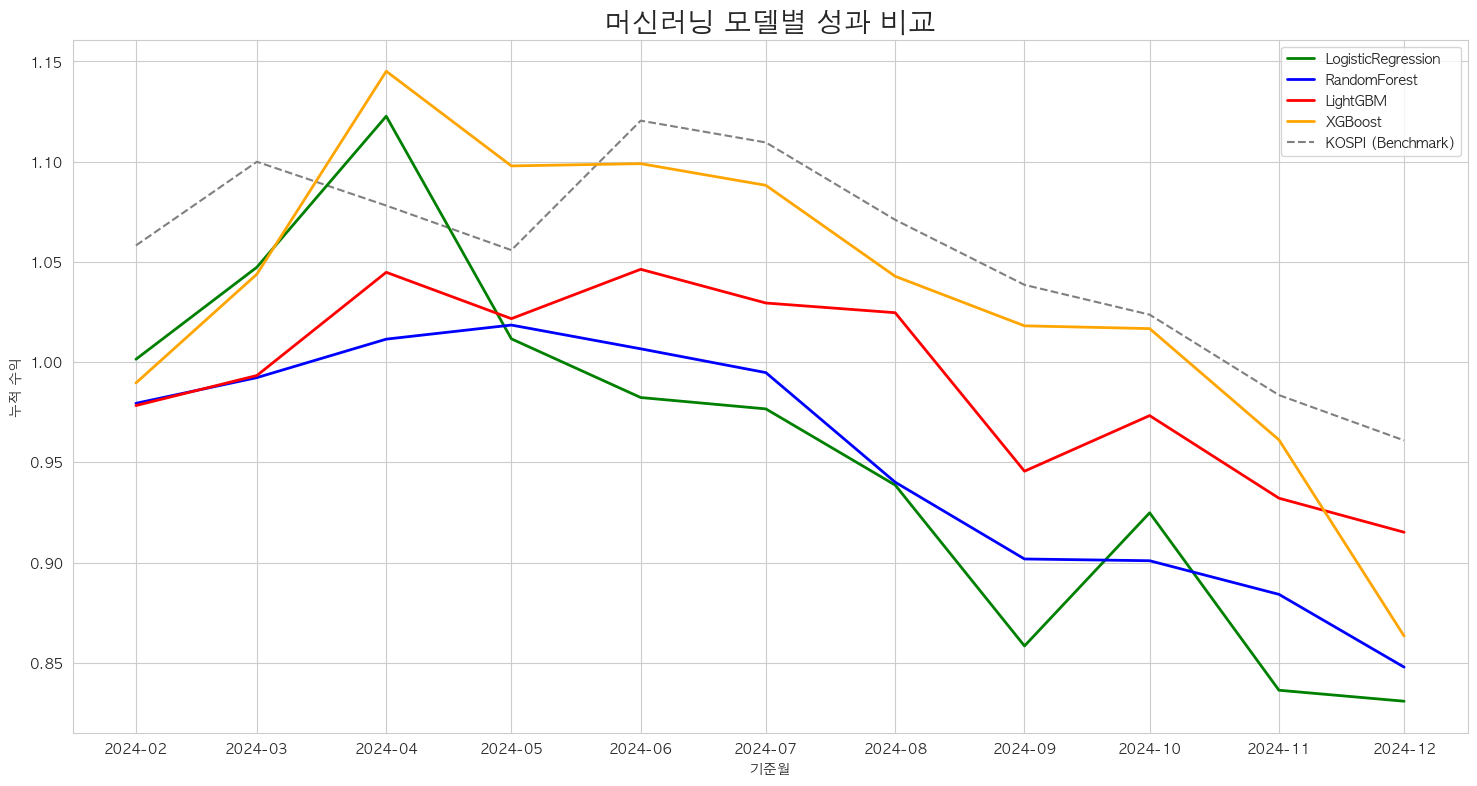

In [25]:
# 파일 이름: 02_run_model_comparison_final.py
# 역할: 3대 머신러닝 모델(로지스틱 회귀, 랜덤 포레스트, LightGBM, XGBoost)을
#       모두 사용하여 백테스팅하고, 그 성과를 종합적으로 비교 분석하는 최종 스크립트.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb # XGBoost 임포트
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib 한글 폰트 설정 ---
try: plt.rc('font', family='AppleGothic')
except: plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 헬퍼 함수 ---
def get_kospi_data_for_caching(start_date, end_date):
    """(캐시 생성용) KOSPI 월별 수익률 데이터를 수집합니다."""
    print("KOSPI 벤치마크 데이터를 다운로드합니다..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last(); kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'수익률': kospi_monthly_returns}).reset_index(); kospi_df_monthly.rename(columns={'Date': '기준월'}, inplace=True)
    kospi_df_monthly['기준월'] = pd.to_datetime(kospi_df_monthly['기준월']).dt.to_period('M').dt.to_timestamp()
    print("✅ KOSPI 데이터 준비 완료!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """성과 지표를 계산하는 헬퍼 함수"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- 최종 비교 백테스터 클래스 ---
class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset; self.df_original = df_original
        self.top_n, self.cost = top_n, cost

    def run_walk_forward_backtest(self, alpha_model, risk_model, model_name, train_months=36, test_months=6):
        """확장 윈도우 방식으로 주어진 듀얼 ML 모델을 학습하고 백테스트 수익률을 반환합니다."""
        print(f"--- 모델: {model_name} | Walk-Forward 백테스트 실행 ---")
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['기준월'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            train_data = dataset[dataset['기준월'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['기준월', '종목코드', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            alpha_model.fit(X_train, y_alpha_train); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['기준월'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(self.top_n * 2, 'alpha_score')
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['종목코드'].tolist()
                
                next_month_date = date + pd.DateOffset(months=1); next_month_data_orig = self.df_original[self.df_original['기준월'] == next_month_date]
                next_month_returns = next_month_data_orig[next_month_data_orig['종목코드'].isin(final_portfolio_stocks)]
                monthly_return = (next_month_returns['1개월수익률'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                monthly_returns.append({'기준월': next_month_date, '수익률': monthly_return})
            
            current_train_end_idx += test_months
        
        return pd.DataFrame(monthly_returns).set_index('기준월')['수익률']

# --- 메인 실행 블록 ---
if __name__ == '__main__':
    print("--- 최종 머신러닝 백테스팅 실행 시작 (모델 비교) ---")
    try:
        # 1. 데이터 로드
        ml_dataset = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/ultimate_ml_dataset.csv", parse_dates=['기준월'])
        df_original = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv", parse_dates=['기준월'])
        
        kospi_filepath = "/Users/gun/Desktop/경종설/퀀트/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['기준월'])
            print("✅ 기존에 저장된 KOSPI 데이터를 불러왔습니다.")
        except FileNotFoundError:
            print("⚠️ 저장된 KOSPI 데이터가 없어 새로 다운로드합니다.")
            start_date, end_date = df_original['기준월'].min(), df_original['기준월'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("✅ 모든 준비된 데이터를 성공적으로 불러왔습니다.")

        # 2. 백테스터 객체 생성
        backtester = DualMachineLearningBacktester(ml_dataset=ml_dataset, df_original=df_original)
        
        # 3. 비교할 모델들 정의
        models_to_test = {
            'LogisticRegression': (LogisticRegression(random_state=42, max_iter=1000), LogisticRegression(random_state=42, max_iter=1000)),
            'RandomForest': (RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
            'LightGBM': (lgb.LGBMClassifier(random_state=42, verbosity=-1), lgb.LGBMClassifier(random_state=42, verbosity=-1)),
            'XGBoost': (xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
        }
        
        all_results = {}; all_returns = {}; train_months = 36

        # 4. 각 모델에 대해 백테스트 실행
        for name, (alpha_model, risk_model) in models_to_test.items():
            returns = backtester.run_walk_forward_backtest(alpha_model, risk_model, name, train_months=train_months, test_months=6)
            all_returns[name] = returns; all_results[name] = calculate_performance_metrics(returns)
        
        # 5. 최종 결과 비교 출력
        print("\n" + "="*60); print(" " * 18 + "- 머신러닝 모델별 최종 성과 비교 -"); print("="*60)
        summary_df = pd.DataFrame.from_dict(all_results, orient='index')
        for col in summary_df.columns:
            summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
        # 6. 최종 결과 시각화
        returns_df_all = pd.concat(all_returns, axis=1); cum_returns = (1 + returns_df_all.fillna(0)).cumprod()
        kospi_returns_aligned = kospi_df.set_index('기준월').loc[cum_returns.index]; cum_returns_kospi = (1 + kospi_returns_aligned['수익률']).cumprod()
        
        plt.figure(figsize=(18, 9)); plt.title('머신러닝 모델별 성과 비교', fontsize=20)
        colors = {'LogisticRegression': 'green', 'RandomForest': 'blue', 'LightGBM': 'red', 'XGBoost': 'orange'}
        for name in models_to_test.keys():
            plt.plot(cum_returns.index, cum_returns[name], label=name, color=colors.get(name), lw=2, zorder=5)
            
        plt.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls='--', zorder=4)
        plt.ylabel('누적 수익'); plt.xlabel('기준월'); plt.legend(); plt.grid(True); plt.show()

    except FileNotFoundError as e:
        print(f"\n!!! 오류: {e} !!!"); print("먼저 '01_build_ultimate_dataset.py'를 실행하여 데이터 파일을 생성해주세요.")
